In [1]:
from tabulate import tabulate
import numpy as np
import matplotlib.pyplot as plt

### Some helper functions

In the rest of the notebook, we will often need to convert between text and binary based representations of strings.

In [2]:
def text2binary(textString):
    binaryString = ''.join(map(lambda c: bin(ord(c))[2:].zfill(8), textString))
    assert len(binaryString) == len(textString) * 8
    return binaryString

def binary2text(binaryString):
    assert len(binaryString) % 8 == 0
    codes = [binaryString[_ : _ + 8] for _ in range(0, len(binaryString), 8)]
    textString = ''.join([chr(int(c, 2)) for c in codes])
    assert len(textString) == len(codes)
    return textString

In [3]:
print(text2binary('Hello World!'))
print(binary2text(text2binary('Hello World!')))

010010000110010101101100011011000110111100100000010101110110111101110010011011000110010000100001
Hello World!


# One time pad

### 1.1) XOR

$\texttt{XOR (x, y)}$ denoted as $x \oplus y$ is the exclusive $\texttt{OR}$ logical operation on two bits $x$ and $y$ defined as

$$ x \oplus y= x + y \,\,\text{mod}\,\, 2$$

In [4]:
def XOR(x, y):
    return str((int(x) + int(y)) % 2)

In [5]:
print('Truth table')
print(tabulate([((x, y), XOR(x, y)) for (x, y) in [(0, 0), (0, 1), (1, 0), (1, 1)]]))

Truth table
------  -
(0, 0)  0
(0, 1)  1
(1, 0)  1
(1, 1)  0
------  -


### 1.2) Secret key

One-time pad is a symmetric encryption algorithm .  As such we need to generate and share a secret key.

In [6]:
def generate_secret_key(number_of_bits):
    return np.random.randint(0, 2, number_of_bits)

Although the one-time pad **cannot be cracked** as we will exemplify in the **perfect secrecy** section, the main drawback is that the shared secret key can only be used to send a single message.  If we already have a way to safely communicate the secret key then we might as well have sent the message directly to begin with...  We will see below that information about the messages can very easily be recovered in case the same secret key is re-used.

### 1.3) Encryption / decryption functions

Now that we have a method to create random secret key $s$, let us consider a plaintext message $m$ encoded as a sequence of bits using the ``text2binary`` method.  One-time pad encryption is given by
\begin{equation}
c \equiv \mathcal{E}(m) = m \oplus s
\end{equation}

If the recipient of the encrypted cipher $c$ also has access to the secret key $s$, the cipher can be decrypted by evaluating

\begin{equation}
\mathcal{D}(c) = c \oplus s
\end{equation}

In order to see why $\mathcal{D}(c)$ always returns the original message, remember that $c = m \oplus s$.  Therefore, $c \oplus s = m \oplus s \oplus s = m$

In [7]:
def sequence_XOR(xs, ys):
    return ''.join([XOR(x, y) for (x, y) in zip(xs, ys)])

def encrypt(message, secret_key):
    assert len(message) == len(secret_key)
    return sequence_XOR(message, secret_key)

def decrypt(cipher, secret_key):
    assert len(cipher) == len(secret_key)
    return sequence_XOR(cipher, secret_key)

## 1) Perfect secrecy

As mentioned above, one-time pad encryption has the remarkable property of being impossible to break.  

In contrast to other encryption schemes, one-time pad is immune even to brute-force attacks.  This is because, given a truly random key that is used only once, a ciphertext can be decrypted into any possible message with equal probability.  This is related to the truth table of $\texttt{XOR}$ that has a 50% chance of returning 0 or 1.   

In other words, the ciphertext $c$ gives absolutely no information about the plaintext $m$ (other than the maximum possible length of the message)

### 1.1) Encrypt a message

In [8]:
message = 'ok'

secret_key = generate_secret_key(len(message) * 8)
print('secret_key = ', ''.join(secret_key.astype(str)))

cipher = encrypt(text2binary(message), secret_key)
print('cipher =     ', cipher)

secret_key =  1011100000001110
cipher =      1101011101100101


### 1.2) Brute-force testing all the possible keys

Let's imagine that we have intercepted the cipher $c$ and try to guess the secret key $s$.  The total number of possible keys grows exponentially with the size of the secret key

In [9]:
number_of_keys = 2 ** len(secret_key)
print(number_of_keys)

65536


As long as the secret key is short, it is quite easy to generate all the possible keys

In [10]:
all_keys = [bin(possible_key)[2:].zfill(len(secret_key)) for possible_key in range(number_of_keys)]

In [11]:
print(all_keys[:15])
print(all_keys[-15:])

['0000000000000000', '0000000000000001', '0000000000000010', '0000000000000011', '0000000000000100', '0000000000000101', '0000000000000110', '0000000000000111', '0000000000001000', '0000000000001001', '0000000000001010', '0000000000001011', '0000000000001100', '0000000000001101', '0000000000001110']
['1111111111110001', '1111111111110010', '1111111111110011', '1111111111110100', '1111111111110101', '1111111111110110', '1111111111110111', '1111111111111000', '1111111111111001', '1111111111111010', '1111111111111011', '1111111111111100', '1111111111111101', '1111111111111110', '1111111111111111']


Then, we can try to decrypt the cipher $c$ using each one of the possible keys and look for a message that makes sense.

In [12]:
all_decryptions = [binary2text(decrypt(cipher, possible_key)) for possible_key in all_keys]

In [13]:
print(all_decryptions[:15])
print(all_decryptions[-15:])

['×e', '×d', '×g', '×f', '×a', '×`', '×c', '×b', '×m', '×l', '×o', '×n', '×i', '×h', '×k']
['(\x94', '(\x97', '(\x96', '(\x91', '(\x90', '(\x93', '(\x92', '(\x9d', '(\x9c', '(\x9f', '(\x9e', '(\x99', '(\x98', '(\x9b', '(\x9a']


Filtering to decryptions composed of lower case ASCII letters, we discover that all possible combinations of letters appear as potential decryptions!

In [14]:
decryptions = filter(lambda d: all([97 <= ord(c) <= 122 for c in d]), all_decryptions)
decryptions = sorted(decryptions)
assert len(decryptions) == 26 * 26
decryptions

['aa',
 'ab',
 'ac',
 'ad',
 'ae',
 'af',
 'ag',
 'ah',
 'ai',
 'aj',
 'ak',
 'al',
 'am',
 'an',
 'ao',
 'ap',
 'aq',
 'ar',
 'as',
 'at',
 'au',
 'av',
 'aw',
 'ax',
 'ay',
 'az',
 'ba',
 'bb',
 'bc',
 'bd',
 'be',
 'bf',
 'bg',
 'bh',
 'bi',
 'bj',
 'bk',
 'bl',
 'bm',
 'bn',
 'bo',
 'bp',
 'bq',
 'br',
 'bs',
 'bt',
 'bu',
 'bv',
 'bw',
 'bx',
 'by',
 'bz',
 'ca',
 'cb',
 'cc',
 'cd',
 'ce',
 'cf',
 'cg',
 'ch',
 'ci',
 'cj',
 'ck',
 'cl',
 'cm',
 'cn',
 'co',
 'cp',
 'cq',
 'cr',
 'cs',
 'ct',
 'cu',
 'cv',
 'cw',
 'cx',
 'cy',
 'cz',
 'da',
 'db',
 'dc',
 'dd',
 'de',
 'df',
 'dg',
 'dh',
 'di',
 'dj',
 'dk',
 'dl',
 'dm',
 'dn',
 'do',
 'dp',
 'dq',
 'dr',
 'ds',
 'dt',
 'du',
 'dv',
 'dw',
 'dx',
 'dy',
 'dz',
 'ea',
 'eb',
 'ec',
 'ed',
 'ee',
 'ef',
 'eg',
 'eh',
 'ei',
 'ej',
 'ek',
 'el',
 'em',
 'en',
 'eo',
 'ep',
 'eq',
 'er',
 'es',
 'et',
 'eu',
 'ev',
 'ew',
 'ex',
 'ey',
 'ez',
 'fa',
 'fb',
 'fc',
 'fd',
 'fe',
 'ff',
 'fg',
 'fh',
 'fi',
 'fj',
 'fk',
 'fl',
 'fm',

This means that trying all possible secret keys only leads to all possible messages and therefore does not really lead to any new information about the ciphertext.

## 2) Reusing the same key more than once

### 2.1) Loading the original images to send

In [15]:
from PIL import Image

IMG_SIZE, THRESH = 500, 200

In [16]:
fn = lambda x : 255 if x > THRESH else 0

im1 = Image.open('figs/sendCash.jpg').resize((IMG_SIZE, IMG_SIZE)).convert('L').point(fn, mode='1')
im2 = Image.open('figs/smiley.jpg').resize((IMG_SIZE, IMG_SIZE)).convert('L').point(fn, mode='1')

msg1, msg2 = 1 * np.asarray(im1), 1 * np.asarray(im2)

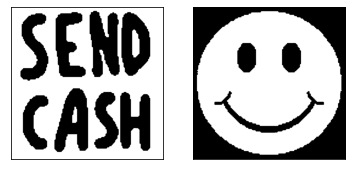

In [17]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(im1); ax[0].set_xticks([]); ax[0].set_yticks([]); 
ax[1].imshow(im2); ax[1].set_xticks([]); ax[1].set_yticks([]);

### 2.2) Create the secret key

The length of the key needs to be the same as the number of pixels in the images

In [18]:
secret_key = generate_secret_key(IMG_SIZE * IMG_SIZE)
print(secret_key.shape)

(250000,)


### 2.3) Encrypt 2 images using the same secret key...

In [19]:
c1 = encrypt(msg1.flatten(), secret_key)
c2 = encrypt(msg2.flatten(), secret_key)

We need a small helper function to transform the ciphers back into images

In [20]:
binStringToArray = lambda binString: np.array(list(binString), dtype=int)

c1_img = binStringToArray(c1).reshape(IMG_SIZE, IMG_SIZE)
c2_img = binStringToArray(c2).reshape(IMG_SIZE, IMG_SIZE)

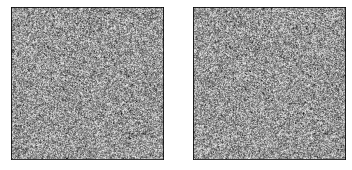

In [21]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(c1_img, cmap='Greys'); ax[0].set_xticks([]); ax[0].set_yticks([]); 
ax[1].imshow(c2_img, cmap='Greys'); ax[1].set_xticks([]); ax[1].set_yticks([]);

### 2.4) Exploit the key re-use!

Assume that the adversary was able to intercept both ciphers. Even though individually those ciphers reveal absolutely no information about the original images, evaluating $c_1 \oplus c_2$ allows us to retrieve significant amount of information

In [22]:
c1c2 = sequence_XOR(c1, c2)

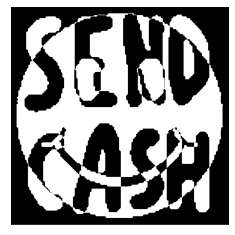

In [23]:
fig, ax = plt.subplots(1,1)
ax.imshow(binStringToArray(c1c2).reshape(IMG_SIZE, IMG_SIZE), cmap='Greys')
ax.set_xticks([]); ax.set_yticks([]);

This can easily be understood by following the logic below

\begin{equation}
\begin{pmatrix}
c_1 = m_1 \oplus s \\
c_2 = m_2 \oplus s
\end{pmatrix} \,\, \Longrightarrow \,\, c_1 \oplus c_2 = m_1 \oplus m_2 \oplus s \oplus s \quad \text{so that} \quad c_1\oplus c_2 = m_1 \oplus m_2
\end{equation}

This shows that an adversary who intercepts 2 messages encrypted by the same secret key $s$ has direct access to the XOR between the 2 orinigal messages.  In the case of images, it is visually obvious how knowledge of $x_1 \oplus x_2$ leaks information about the individual $x_1$ and $x_2$.  

In general, a significant amount of information can be extracted about the messages for any kind of data modality. 

## 3) Malleability

### 3.1) Going to the ATM...


Imagine going to your local ATM to withdraw $10 from your bank account. In order to complete the withdrawal, the ATM may send a encrypted message of the type below to the bank

$$\texttt{Withdraw \$10 from ... unknown connection and bank details that somehow points to my personal account ...}$$

In [24]:
message = 'Withdraw $10 from ... unknown bank details that somehow points to my personal account ...'

secret_key = generate_secret_key(len(message) * 8)

real_cipher = encrypt(text2binary(message), secret_key)

print('\nencrypted message sent from ATM to the bank = ', real_cipher)


encrypted message sent from ATM to the bank =  0100111100001101000010100011110101000100110101111010100001001010011111011001110011111011111100110001101011000000000001111010011010100101110100100011111110101100110000000011111000010011100100000000010111111100110000011101100001100001000001011111000100110001000111001100100010001100110010001010010100001010111001000010010000111101110010101000001111011010100011001000000100100101011110110110110111010110000001000110111111101001110001111111101110011010000010001001100100101011100011101110111011000110000000101100101010001010011001000111010101000010110110001010110001010000111111000011011100010010001000101101010110000010100010100110101010010011000111101010111111000100011010001110011110100011100111111110100010011101


### 3.2) Intercepting and modifying the cipher

All we need to know is that the message starts with $\quad \texttt{Withdraw \$10 from} \quad$ 

All the rest of the message may contain all kinds of unknown connection and bank specific instructions that eventually lead to my personal account.

In [25]:
known_submessage = 'Withdraw $10 from'

known_numbBits = len(known_submessage) * 8

We can prepare a new message that is intended to replace this known part of the original message

In [26]:
poisoned_submessage = 'Deposit $10000 to'

assert len(poisoned_submessage) * 8 == known_numbBits

Prepare a sequence of attack bits in order to modify the cipher sent by the ATM

In [27]:
attack_cipher = sequence_XOR(text2binary(known_submessage), text2binary(poisoned_submessage))
poisoned_cipher = sequence_XOR(real_cipher[:known_numbBits], attack_cipher)

Replace the first few bits of the intercepted ``cipher`` by a poisoned cipher

In [28]:
modified_cipher = poisoned_cipher + real_cipher[known_numbBits:]

assert len(modified_cipher) == len(real_cipher)

### 3.3) The bank gets the modified cipher

Assuming that we were fast enough and we were able to modify the ``real_cipher`` and pass forward the ``modified_cipher`` on to the bank, the decrypted message reads

In [29]:
binary2text(decrypt(modified_cipher, secret_key))

'Deposit $10000 to ... unknown bank details that somehow points to my personal account ...'

In other words, we have changed the withdrawal message into a new message

$$\texttt{Deposit \$10000 to ... unknown connection and bank details that somehow points to my personal account ...}$$

by modifying the cipher in a targeted way without ever having had access to the secret key